# Import Libraries

This is a linear regression model used to predict the google shares based on data from quandl

In [1]:
import pandas as pd
import quandl
import math, datetime
import numpy as np
from sklearn import preprocessing, svm # or from sklearn.model_selection import cross_validate, train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pickle
from matplotlib import style
style.use('ggplot')

# Read File from Quandl-
Note: the file name is as stated on Quandl. you can download or use the quandl.get command

In [2]:
df = quandl.get('WIKI/GOOGL')
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


# Remove irrelevant columns and retain the relevant ones

In [3]:
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
df

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,
2004-08-19,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,52.542193,54.167209,52.100830,53.164113,9188600.0
...,...,...,...,...,...
2018-03-21,1092.570000,1108.700000,1087.210000,1094.000000,1990515.0
2018-03-22,1080.010000,1083.920000,1049.640000,1053.150000,3418154.0
2018-03-23,1051.370000,1066.780000,1024.870000,1026.550000,2413517.0


# Get %volatility in stock. i.e high minus close

In [4]:
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low'])/df['Adj. Close'] * 100
df['HL_PCT']

Date
2004-08-19    8.072956
2004-08-20    7.921706
2004-08-23    4.049360
2004-08-24    7.657099
2004-08-25    3.886792
                ...   
2018-03-21    1.964351
2018-03-22    3.254997
2018-03-23    4.082607
2018-03-26    4.619150
2018-03-27    6.645878
Name: HL_PCT, Length: 3424, dtype: float64

# Get % change(%volatility) in stock. i.e open minus close

In [5]:
df['CHANGE_PCT'] = (df['Adj. Close'] - df['Adj. Open'])/df['Adj. Open'] * 100
df['CHANGE_PCT']

Date
2004-08-19    0.324968
2004-08-20    7.227007
2004-08-23   -1.227880
2004-08-24   -5.726357
2004-08-25    1.183658
                ...   
2018-03-21    0.130884
2018-03-22   -2.487014
2018-03-23   -2.360729
2018-03-26    0.332191
2018-03-27   -5.353887
Name: CHANGE_PCT, Length: 3424, dtype: float64

# Define a new database. i.e only column we care about

In [6]:
df = df[['Adj. Close', 'HL_PCT', 'CHANGE_PCT', 'Adj. Volume']]
df

,Adj. Close,HL_PCT,CHANGE_PCT,Adj. Volume
Date,,,,
2004-08-19,50.322842,8.072956,0.324968,44659000.0
2004-08-20,54.322689,7.921706,7.227007,22834300.0
2004-08-23,54.869377,4.049360,-1.227880,18256100.0
2004-08-24,52.597363,7.657099,-5.726357,15247300.0
2004-08-25,53.164113,3.886792,1.183658,9188600.0
...,...,...,...,...
2018-03-21,1094.000000,1.964351,0.130884,1990515.0
2018-03-22,1053.150000,3.254997,-2.487014,3418154.0
2018-03-23,1026.550000,4.082607,-2.360729,2413517.0


# Define forcast column

In [7]:
forecast_col = 'Adj. Close'
df.fillna(-99999, inplace=True)
forecast_out = int(math.ceil(0.1*len(df)))

C:\Users\HP EliteBook 840\Anaconda3\lib\site-packages\pandas\core\frame.py:4259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


# Define Label

In [8]:
df['Label'] = df[forecast_col].shift(-forecast_out)
df.dropna(inplace=True)
print(df.head())
print(df.tail())

            Adj. Close    HL_PCT  CHANGE_PCT  Adj. Volume       Label
Date                                                                 
2004-08-19   50.322842  8.072956    0.324968   44659000.0  214.005615
2004-08-20   54.322689  7.921706    7.227007   22834300.0  210.725489
2004-08-23   54.869377  4.049360   -1.227880   18256100.0  208.072299
2004-08-24   52.597363  7.657099   -5.726357   15247300.0  218.288837
2004-08-25   53.164113  3.886792    1.183658    9188600.0  223.309335
            Adj. Close    HL_PCT  CHANGE_PCT  Adj. Volume    Label
Date                                                              
2016-11-04      781.10  2.237319    1.270582    1970603.0  1094.00
2016-11-07      802.03  1.508672    0.890622    1992570.0  1053.15
2016-11-08      811.98  2.022217    1.240602    1769069.0  1026.55
2016-11-09      805.59  2.442309    0.468927    3098510.0  1054.09
2016-11-10      780.29  5.360827   -3.667901    5909609.0  1006.94


C:\Users\HP EliteBook 840\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\HP EliteBook 840\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
X = np.array(df.drop(['Label'], 1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]


In [10]:
y = np.array(df['Label'])
df.dropna(inplace=True)

C:\Users\HP EliteBook 840\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
print(len(X), len(y))

3081 3081


# Split Data to Train and Test

In [12]:
X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, test_size = 0.2)

In [13]:
clf = LinearRegression() 
clf.fit(X_Train, y_Train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [14]:
accuracy = clf.score(X_Test, y_Test) # Score is synounymous to test
print(accuracy)

0.8930853541582445


In [15]:
forecast_set = clf.predict(X_lately)
print(forecast_set, accuracy, forecast_out)

[ 695.96664831  680.23700218  679.85078313  697.56869598  726.22822906
  740.89568576  732.93873837  761.30967631  880.15345395  870.37447849
  881.08616865  880.12941088  858.17093514  833.8675687   830.7376804
  827.84348636  829.70486038  840.3590026   821.63705603  832.80172247
  826.62866392  848.85659983  843.8358953   833.05463291  832.75046146
  870.11195957  870.26212915  861.60896229  863.33073429  871.79687282
  863.29242003  871.98559954  861.3527982   826.24386222  821.914008
  796.5174605   850.10444147  849.98806578  830.32501959  821.2935938
  800.45154734  814.51312727  807.74130596  787.10745216  810.36095644
  814.02658429  821.18367907  819.75838187  814.43271421  840.32574482
  830.16148422  849.00044552  826.09960065  837.01634558  822.25949036
  819.24193697  826.72320487  811.98187856  800.42114993  789.4746216
  799.42919569  808.63499308  840.90508791  850.08707174  847.71350051
  850.58200721  843.94158371  843.51895266  849.24141551  861.64742789
  853.67671

In [16]:
df['Forecast'] = np.nan

C:\Users\HP EliteBook 840\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

In [18]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix =+ one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]

C:\Users\HP EliteBook 840\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\HP EliteBook 840\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


# Visualise model 

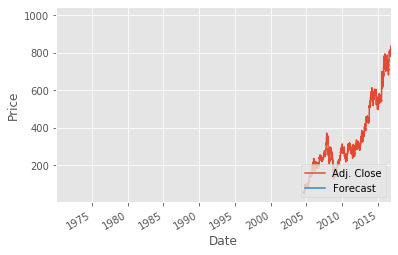

In [19]:
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()